<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/bert_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.tensorflow.org/tutorials/text/classify_text_with_bert


In [1]:
!pip install -U -q tensorflow-text
!pip install -U -q tf-models-official

     |████████████████████████████████| 3.4MB 20.0MB/s 
     |████████████████████████████████| 1.1MB 17.2MB/s 
     |████████████████████████████████| 37.6MB 81kB/s 
     |████████████████████████████████| 1.2MB 56.7MB/s 
     |████████████████████████████████| 102kB 16.6MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 645kB 50.5MB/s 
     |████████████████████████████████| 706kB 51.5MB/s 
     |████████████████████████████████| 358kB 62.2MB/s 
     |████████████████████████████████| 174kB 56.7MB/s 


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow_hub import KerasLayer
import tensorflow_text
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 2021
epochs = 100
lr = 3e-5
earlystopping_patience = 4

In [4]:
# Download the IMDB dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir=".", cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# Training dataset
raw_train_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)
class_names = raw_train_ds.class_names
print("Class names: {}".format(class_names))
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Validation dataset
val_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tesing dataset
test_ds = text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

84131840/84125825 [==============================] - 4s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Class names: ['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
# Choose a BERT model to fine-tune

map_name_to_handle = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_base/2",
    "electra_small":
        "https://tfhub.dev/google/electra_small/2",
    "electra_base":
        "https://tfhub.dev/google/electra_base/2",
    "experts_pubmed":
        "https://tfhub.dev/google/experts/bert/pubmed/2",
    "experts_wiki_books":
        "https://tfhub.dev/google/experts/bert/wiki_books/2",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1",
}

map_model_to_preprocess = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_preprocess/2",
    "electra_small":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "electra_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_pubmed":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_wiki_books":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
}

bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8" 
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["binary_accuracy"]
  val_acc = history_dict["val_binary_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 244ms/step - loss: 0.7045 - binary_accuracy: 0.5317 - val_loss: 0.5320 - val_binary_accuracy: 0.7092
Epoch 2/100
563/563 [==============================] - 138s 246ms/step - loss: 0.5080 - binary_accuracy: 0.7330 - val_loss: 0.4258 - val_binary_accuracy: 0.7970
Epoch 3/100
563/563 [==============================] - 139s 247ms/step - loss: 0.4026 - binary_accuracy: 0.8104 - val_loss: 0.4515 - val_binary_accuracy: 0.7782
Epoch 4/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3440 - binary_accuracy: 0.8432 - val_loss: 0.3818 - val_binary_accuracy: 0.8336
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3075 - binary_accuracy: 0.8646 - val_loss: 0.4172 - val_binary_accuracy: 0.8320
Epoch 6/100
563/563 [==============================] - 138s 246ms/step - loss: 0.2588 

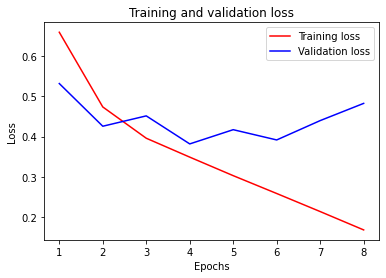

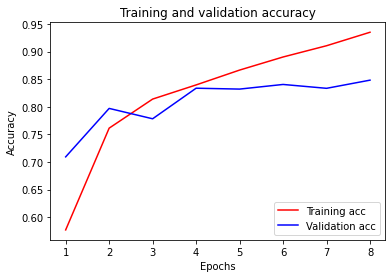

              precision    recall  f1-score   support

           0      0.836     0.857     0.846     12500
           1      0.853     0.832     0.842     12500

    accuracy                          0.844     25000
   macro avg      0.844     0.844     0.844     25000
weighted avg      0.844     0.844     0.844     25000


KFold: 2 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 248ms/step - loss: 0.7516 - binary_accuracy: 0.5258 - val_loss: 0.5489 - val_binary_accuracy: 0.6818
Epoch 2/100
563/563 [==============================] - 139s 248ms/step - loss: 0.5140 - binary_accuracy: 0.7290 - val_loss: 0.4260 - val_binary_accuracy: 0.7968
Epoch 3/100
563/563 [==============================] - 140s 249ms/step - loss: 0.4127 - binary_accuracy: 0.8022 - val_loss: 0.4233 - val_binary_accuracy: 0.7922
Epoch 4/100
563/563 [==============================] - 140s 249ms/step - loss: 0

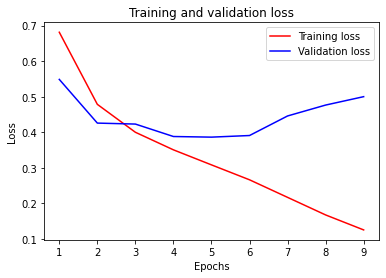

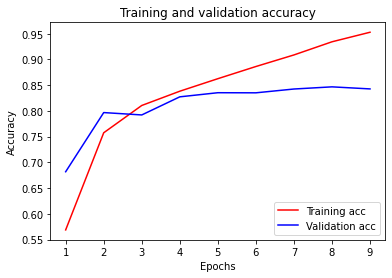

              precision    recall  f1-score   support

           0      0.827     0.876     0.851     12500
           1      0.868     0.817     0.842     12500

    accuracy                          0.846     25000
   macro avg      0.847     0.846     0.846     25000
weighted avg      0.847     0.846     0.846     25000


KFold: 3 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 248ms/step - loss: 0.7388 - binary_accuracy: 0.5343 - val_loss: 0.5234 - val_binary_accuracy: 0.7300
Epoch 2/100
563/563 [==============================] - 140s 249ms/step - loss: 0.4975 - binary_accuracy: 0.7378 - val_loss: 0.4326 - val_binary_accuracy: 0.8030
Epoch 3/100
563/563 [==============================] - 140s 249ms/step - loss: 0.4020 - binary_accuracy: 0.8129 - val_loss: 0.3959 - val_binary_accuracy: 0.8156
Epoch 4/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3549 - binary_accuracy: 0.8386 - val_loss: 0.3967 - val_binary_accuracy: 0.8126
Epoch 5/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3143 - binary_accuracy: 0.8616 - val_loss: 0.3818 - val_binary_accuracy: 0.8416
Epoch 6/100
563/563 [==============================] - 139s 248ms/step - loss: 0.2556 - binary_accuracy

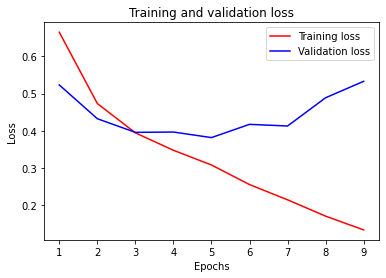

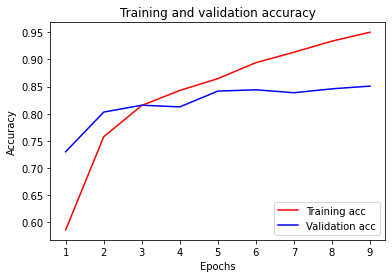

              precision    recall  f1-score   support

           0      0.837     0.868     0.852     12500
           1      0.863     0.832     0.847     12500

    accuracy                          0.850     25000
   macro avg      0.850     0.850     0.850     25000
weighted avg      0.850     0.850     0.850     25000


KFold: 4 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 144s 248ms/step - loss: 0.7096 - binary_accuracy: 0.5318 - val_loss: 0.5529 - val_binary_accuracy: 0.6854
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.5153 - binary_accuracy: 0.7259 - val_loss: 0.4333 - val_binary_accuracy: 0.7982
Epoch 3/100
563/563 [==============================] - 139s 248ms/step - loss: 0.3987 - binary_accuracy: 0.8081 - val_loss: 0.4113 - val_binary_accuracy: 0.8034
Epoch 4/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3491 - binary_accuracy: 0.8394 - val_loss: 0.3779 - val_binary_accuracy: 0.8296
Epoch 5/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3105 - binary_accuracy: 0.8613 - val_loss: 0.3922 - val_binary_accuracy: 0.8252
Epoch 6/100
563/563 [==============================] - 141s 251ms/step - loss: 0.2644 - binary_accuracy

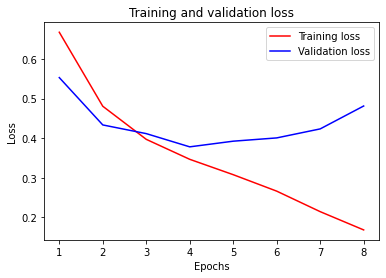

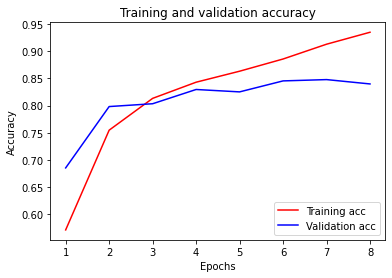

              precision    recall  f1-score   support

           0      0.819     0.873     0.845     12500
           1      0.864     0.807     0.834     12500

    accuracy                          0.840     25000
   macro avg      0.841     0.840     0.840     25000
weighted avg      0.841     0.840     0.840     25000


KFold: 5 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 148s 253ms/step - loss: 0.7210 - binary_accuracy: 0.5196 - val_loss: 0.5617 - val_binary_accuracy: 0.6646
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.5265 - binary_accuracy: 0.7155 - val_loss: 0.4374 - val_binary_accuracy: 0.7736
Epoch 3/100
563/563 [==============================] - 141s 250ms/step - loss: 0.4111 - binary_accuracy: 0.8045 - val_loss: 0.4113 - val_binary_accuracy: 0.7950
Epoch 4/100
563/563 [==============================] - 142s 252ms/step - loss: 0.3567 - binary_accuracy: 0.8350 - val_loss: 0.4103 - val_binary_accuracy: 0.8040
Epoch 5/100
563/563 [==============================] - 142s 252ms/step - loss: 0.3123 - binary_accuracy: 0.8631 - val_loss: 0.3662 - val_binary_accuracy: 0.8398
Epoch 6/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2617 - binary_accuracy

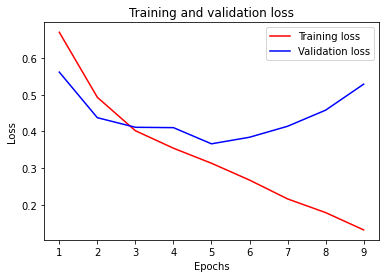

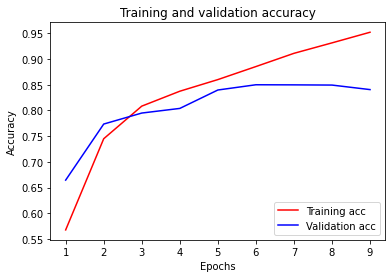

              precision    recall  f1-score   support

           0      0.828     0.879     0.852     12500
           1      0.871     0.817     0.843     12500

    accuracy                          0.848     25000
   macro avg      0.849     0.848     0.848     25000
weighted avg      0.849     0.848     0.848     25000


KFold: 6 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 146s 250ms/step - loss: 0.7091 - binary_accuracy: 0.5310 - val_loss: 0.5388 - val_binary_accuracy: 0.7010
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.5159 - binary_accuracy: 0.7300 - val_loss: 0.4290 - val_binary_accuracy: 0.7942
Epoch 3/100
563/563 [==============================] - 141s 250ms/step - loss: 0.4035 - binary_accuracy: 0.8094 - val_loss: 0.3901 - val_binary_accuracy: 0.8164
Epoch 4/100
563/563 [==============================] - 141s 250ms/step - loss: 0.3614 - binary_accuracy: 0.8324 - val_loss: 0.3845 - val_binary_accuracy: 0.8334
Epoch 5/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2986 - binary_accuracy: 0.8680 - val_loss: 0.3735 - val_binary_accuracy: 0.8398
Epoch 6/100
563/563 [==============================] - 141s 251ms/step - loss: 0.2583 - binary_accuracy

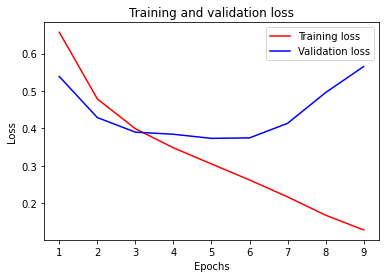

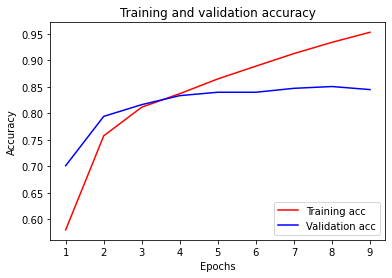

              precision    recall  f1-score   support

           0      0.822     0.886     0.853     12500
           1      0.876     0.808     0.841     12500

    accuracy                          0.847     25000
   macro avg      0.849     0.847     0.847     25000
weighted avg      0.849     0.847     0.847     25000


KFold: 7 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 146s 250ms/step - loss: 0.8681 - binary_accuracy: 0.5202 - val_loss: 0.5688 - val_binary_accuracy: 0.6888
Epoch 2/100
563/563 [==============================] - 141s 251ms/step - loss: 0.5362 - binary_accuracy: 0.7057 - val_loss: 0.4395 - val_binary_accuracy: 0.7888
Epoch 3/100
563/563 [==============================] - 141s 251ms/step - loss: 0.4121 - binary_accuracy: 0.8056 - val_loss: 0.4081 - val_binary_accuracy: 0.8138
Epoch 4/100
563/563 [==============================] - 141s 250ms/step - loss: 0.3669 - binary_accuracy: 0.8299 - val_loss: 0.4291 - val_binary_accuracy: 0.8198
Epoch 5/100
563/563 [==============================] - 141s 250ms/step - loss: 0.3217 - binary_accuracy: 0.8547 - val_loss: 0.3934 - val_binary_accuracy: 0.8306
Epoch 6/100
563/563 [==============================] - 141s 251ms/step - loss: 0.2652 - binary_accuracy

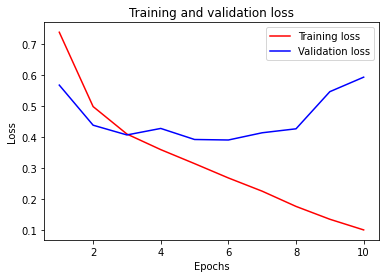

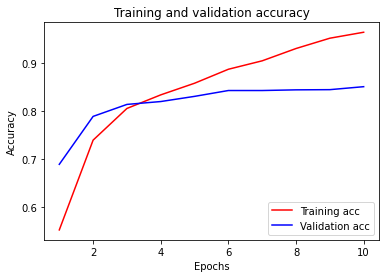

              precision    recall  f1-score   support

           0      0.836     0.871     0.853     12500
           1      0.865     0.829     0.847     12500

    accuracy                          0.850     25000
   macro avg      0.850     0.850     0.850     25000
weighted avg      0.850     0.850     0.850     25000


KFold: 8 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 147s 251ms/step - loss: 0.7182 - binary_accuracy: 0.5140 - val_loss: 0.5160 - val_binary_accuracy: 0.7326
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.4974 - binary_accuracy: 0.7402 - val_loss: 0.4310 - val_binary_accuracy: 0.7972
Epoch 3/100
563/563 [==============================] - 141s 251ms/step - loss: 0.4002 - binary_accuracy: 0.8106 - val_loss: 0.3954 - val_binary_accuracy: 0.8218
Epoch 4/100
563/563 [==============================] - 142s 252ms/step - loss: 0.3499 - binary_accuracy: 0.8384 - val_loss: 0.3842 - val_binary_accuracy: 0.8276
Epoch 5/100
563/563 [==============================] - 142s 252ms/step - loss: 0.3084 - binary_accuracy: 0.8636 - val_loss: 0.4390 - val_binary_accuracy: 0.8308
Epoch 6/100
563/563 [==============================] - 141s 251ms/step - loss: 0.2616 - binary_accuracy

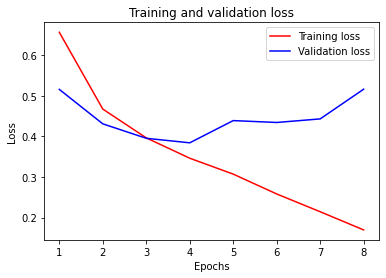

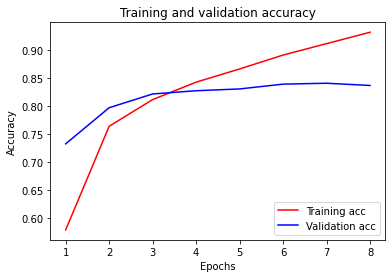

              precision    recall  f1-score   support

           0      0.788     0.910     0.844     12500
           1      0.893     0.755     0.818     12500

    accuracy                          0.832     25000
   macro avg      0.840     0.832     0.831     25000
weighted avg      0.840     0.832     0.831     25000


KFold: 9 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 148s 251ms/step - loss: 0.6842 - binary_accuracy: 0.5779 - val_loss: 0.5190 - val_binary_accuracy: 0.7464
Epoch 2/100
563/563 [==============================] - 141s 251ms/step - loss: 0.4888 - binary_accuracy: 0.7521 - val_loss: 0.4270 - val_binary_accuracy: 0.7996
Epoch 3/100
563/563 [==============================] - 141s 251ms/step - loss: 0.3954 - binary_accuracy: 0.8171 - val_loss: 0.4002 - val_binary_accuracy: 0.8190
Epoch 4/100
563/563 [==============================] - 141s 251ms/step - loss: 0.3546 - binary_accuracy: 0.8367 - val_loss: 0.4027 - val_binary_accuracy: 0.8270
Epoch 5/100
563/563 [==============================] - 141s 251ms/step - loss: 0.3017 - binary_accuracy: 0.8683 - val_loss: 0.3872 - val_binary_accuracy: 0.8356
Epoch 6/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2609 - binary_accuracy

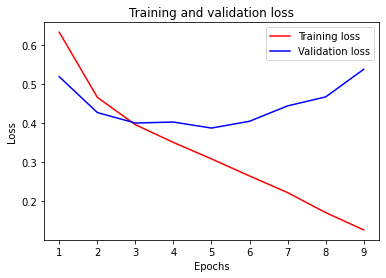

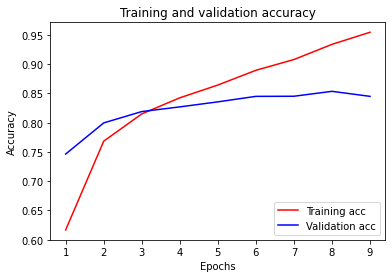

              precision    recall  f1-score   support

           0      0.806     0.900     0.850     12500
           1      0.887     0.783     0.832     12500

    accuracy                          0.841     25000
   macro avg      0.846     0.841     0.841     25000
weighted avg      0.846     0.841     0.841     25000


KFold: 10 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 149s 255ms/step - loss: 0.7165 - binary_accuracy: 0.5114 - val_loss: 0.5420 - val_binary_accuracy: 0.6764
Epoch 2/100
563/563 [==============================] - 143s 254ms/step - loss: 0.5109 - binary_accuracy: 0.7299 - val_loss: 0.4218 - val_binary_accuracy: 0.7970
Epoch 3/100
563/563 [==============================] - 143s 254ms/step - loss: 0.4083 - binary_accuracy: 0.8065 - val_loss: 0.3971 - val_binary_accuracy: 0.8132
Epoch 4/100
563/563 [==============================] - 142s 253ms/step - loss: 0.3557 - binary_accuracy: 0.8335 - val_loss: 0.3790 - val_binary_accuracy: 0.8274
Epoch 5/100
563/563 [==============================] - 143s 254ms/step - loss: 0.3048 - binary_accuracy: 0.8644 - val_loss: 0.3919 - val_binary_accuracy: 0.8340
Epoch 6/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2689 - binary_accuracy

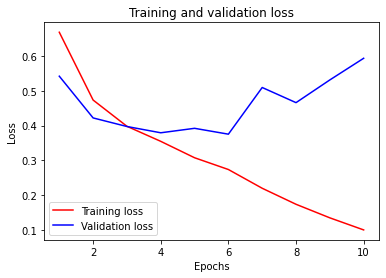

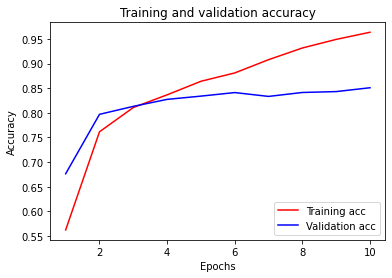

              precision    recall  f1-score   support

           0      0.807     0.906     0.853     12500
           1      0.892     0.783     0.834     12500

    accuracy                          0.844     25000
   macro avg      0.849     0.844     0.844     25000
weighted avg      0.849     0.844     0.844     25000


Average accuracy: 0.8443 (+/- 0.0051)
Average loss: 0.3567 (+/- 0.0063)
Average F1: 0.8379 (+/- 0.0083)


In [7]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []
n = 1

x_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

for train, valid in kfold.split(x_train, y_train):

  print("KFold: {} starts.".format(n))
  del model
  tf.keras.backend.clear_session()

  text_input = Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = KerasLayer(handle=tfhub_handle_preprocess, name="preprocessing")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = KerasLayer(handle=tfhub_handle_encoder, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = Dropout(rate=0.1)(net)
  net = Dense(units=1, activation=None, name="classifier")(net)
  model = Model(inputs=text_input, outputs=net)
  # plot_model(model)

  steps_per_epoch = cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1 * num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type="adamw")

  model.compile(
      optimizer=optimizer,
      loss=BinaryCrossentropy(from_logits=True),
      metrics=tf.metrics.BinaryAccuracy())

  print(f"Training model with {tfhub_handle_encoder}")
  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback])
  
  loss, acc = model.evaluate(test_ds, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  y_test = np.concatenate([y for x, y in test_ds], axis=0)
  y_pred = (model.predict(test_ds) > 0.5).astype("int32")
  report = classification_report(y_true=y_test, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_test, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")
  n += 1

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
